## HEADING

In [2]:
# import modules
import random
import pylab
import pandas as pd
import numpy as np
import cPickle as pkl
from PIL import Image
import matplotlib.pyplot as plt
from lasagne import layers
from lasagne.updates import nesterov_momentum
from theano.tensor.nnet import softmax
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator

Using gpu device 0: GeForce GT 740M (CNMeM is disabled)


In [3]:
# extra functions
def unpickle(filer):
    f = open(filer, 'rb')
    d_dict = pkl.load(f)
    f.close()
    return d_dict

In [4]:
# load train-test set
# cifar
train_dict = unpickle('/home/faizy/workspace/cifar/cifar-10-batches-py/data_batch_1')
train2_images = train_dict['data'].astype('float32')
train2_y = np.zeros((10000, )).astype('int')
test_dict = unpickle('/home/faizy/workspace/cifar/cifar-10-batches-py/test_batch')
test2_images = test_dict['data'].astype('float32')

# mnist
train1 = pd.read_csv("train.csv")
test1 = pd.read_csv("test.csv")

(-0.5, 31.5, 31.5, -0.5)

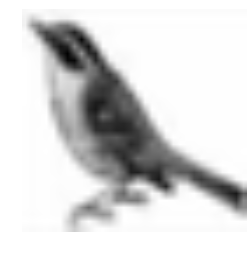

In [5]:
# visualize train set
# cifar
%matplotlib inline
i = random.randrange(0, 10000)
img = train2_images[i, :]
img = img.reshape(3, 32, 32).transpose(1, 2, 0)
pylab.imshow(img[:, :, 0])
pylab.gray()
pylab.axis('off')

In [6]:
# preprocess
# cifar
train2_images /= train2_images.std(axis = None)
train2_images -= train2_images.mean()

test2_images /= test2_images.std(axis = None)
test2_images -= test2_images.mean()

# mnist
train1_labels = np.ones((42000, )).astype(np.int32)
train1_images = train1.ix[:, 1:].values.astype(np.float32)
train1_images /= train1_images.std(axis = None)
train1_images -= train1_images.mean()

test1_images = test1.values.astype(np.float32)
test1_images /= test1_images.std(axis = None)
test1_images -= test1_images.mean()

In [7]:
# reshape dataset
# cifar
# grayscaling and cropping to size
train2_x_rgb = train2_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

train2_x = np.zeros((10000, 1, 32, 32))
for i in range(10000):
    train2_x[i, :, :, :] = np.dot(train2_x_rgb[i, :, :, :], [0.299, 0.587, 0.144])

train2_x = train2_x[:, :, 2:30, 2:30]

test2_x_rgb = test2_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

test2_x = np.zeros((10000, 1, 32, 32))
for i in range(10000):
    test2_x[i, :, :, :] = np.dot(test2_x_rgb[i, :, :, :], [0.299, 0.587, 0.144])

test2_x = test2_x[:, :, 2:30, 2:30]

# mnist
train1_x = train1_images.reshape(-1, 1, 28, 28)
train1_y = train1_labels

test1_x = test1_images.reshape(-1, 1, 28, 28)

In [8]:
# finally
train_x = np.vstack((train1_x, train2_x))

train_y = np.concatenate([train1_y, train2_y])

test_x = np.vstack((test1_x, test2_x))

In [9]:
# check again
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')

In [10]:
# setting nn 
net = NeuralNet(
    layers = [
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('hidden3', layers.DenseLayer),
        ('output', layers.DenseLayer),
    ],

    input_shape = (None, 1, 28, 28),
    conv1_num_filters = 32, conv1_filter_size = (3, 3),
    pool1_pool_size = (2, 2),
    dropout1_p = 0.2,
    conv2_num_filters = 32, conv2_filter_size = (2, 2),
    pool2_pool_size = (2, 2),
    dropout2_p = 0.2,
    hidden3_num_units = 32,
    output_num_units = 2, output_nonlinearity = softmax,

    batch_iterator_train = BatchIterator(batch_size = 1000),
    batch_iterator_test = BatchIterator(batch_size = 1000),

    update=nesterov_momentum,
    update_learning_rate = 0.003,
    update_momentum = 0.9,

    use_label_encoder = True,
    regression = False,
    max_epochs = 10,
    verbose = 1,
)

In [11]:
# train and test nn
net.fit(train_x, train_y)
pred = net.predict(test_x)

# Neural Network with 41410 learnable parameters

## Layer information

  #  name      size
---  --------  --------
  0  input     1x28x28
  1  conv1     32x26x26
  2  pool1     32x13x13
  3  dropout1  32x13x13
  4  conv2     32x12x12
  5  pool2     32x6x6
  6  dropout2  32x6x6
  7  hidden3   32
  8  output    2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       0.45422       0.66413      0.68393      0.68641  17.76s
      2       0.64886       0.34135      1.90090      0.78223  18.14s
      3       0.23455       0.18606      1.26065      0.95282  18.11s
      4       0.14996       0.10555      1.42077      0.97705  18.50s
      5       0.09773       0.07103      1.37593      0.98636  18.47s


--------------
It is a number


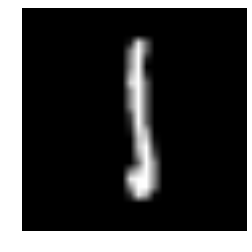

In [13]:
# visualize output
%matplotlib inline
i = random.randrange(0, 28000)
img = test_x[i, :]
img = img.reshape(28, 28)
pylab.imshow(img)
pylab.gray()
pylab.axis('off')
print '--------------'
if pred[i] == 1:
    print "It is a number"
else:
    print "It is NOT a number"

--------------
It is NOT a number


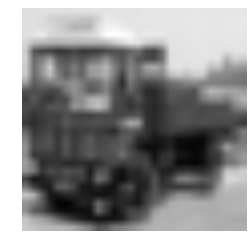

In [16]:
# visualize output
%matplotlib inline
i = random.randrange(28000, 38000)
img = test_x[i, :]
img = img.reshape(28, 28)
pylab.imshow(img)
pylab.gray()
pylab.axis('off')
print '--------------'
if pred[i] == 1:
    print "It is a number"
else:
    print "It is NOT a number"